In [1]:
import matplotlib.pyplot as plt
import torch
from scipy.io import loadmat
import numpy as np

%load_ext autoreload
%autoreload 2
%matplotlib inline

device = torch.device("mps")
#device = "cpu"
print(device, torch.__version__)
#torch.manual_seed(1802)

mps 2.7.0


In [2]:
mat = loadmat("../data/fan_flutter.mat")["x"]
x_sample = torch.from_numpy(mat).float()[:, 4_000:10_000]

reg = 0.01

def entropy_loss(x):
    x1 = torch.reshape(x, (x.shape[0], -1))  # B, N
    probs = torch.div(x1.T, x1.sum(dim=-1)).T  # B, N
    entropy = -(
        probs * torch.clamp(torch.log(probs), min=torch.finfo(x.dtype).min)
    ).sum(
        dim=-1,
    )  # B
    return entropy.mean()

import time
tic_time = None
def tic():
    global tic_time
    tic_time = time.time()
def toc(print_elapsed=True):
    global tic_time
    elapsed = time.time() - tic_time
    if print_elapsed:
        print(f"Elapsed time: {elapsed:.4f} seconds")
    return elapsed

Here, the fastDSTFT is tested

Using the 'low' memory intensity stft()


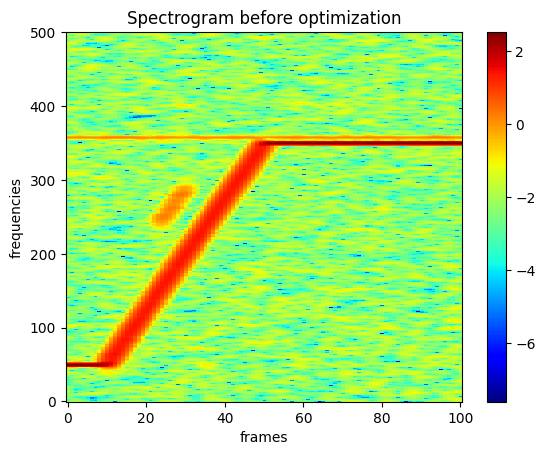

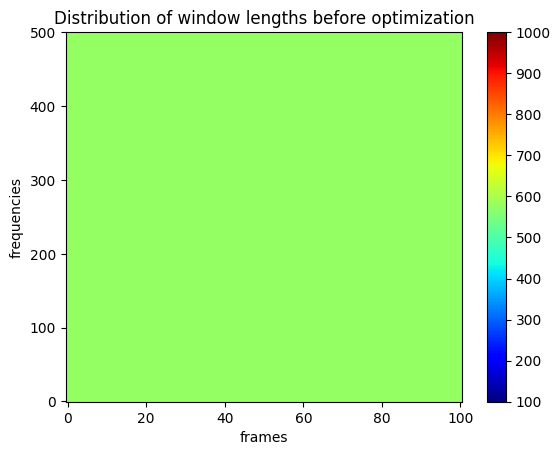

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


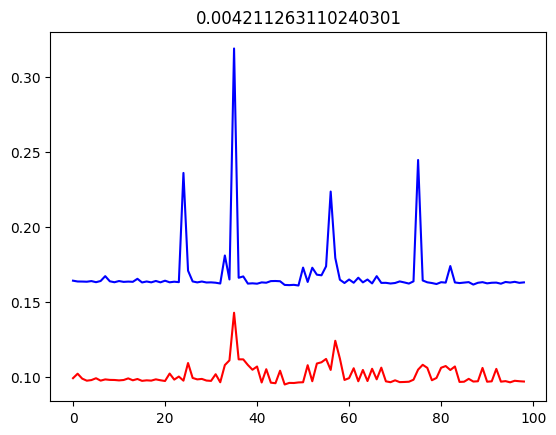

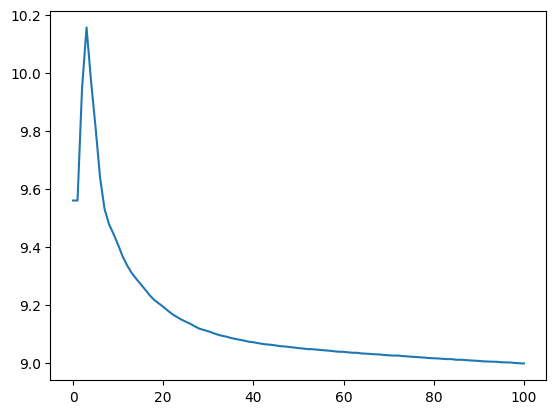

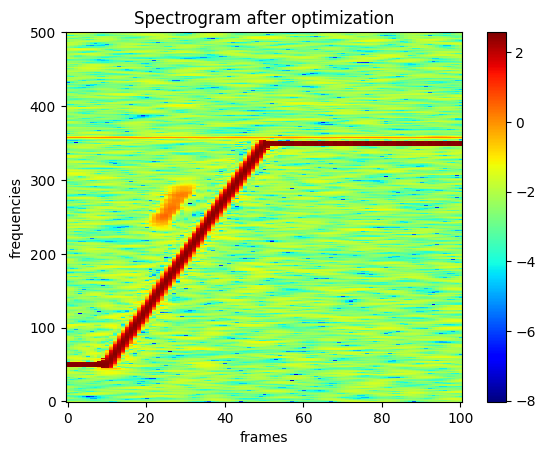

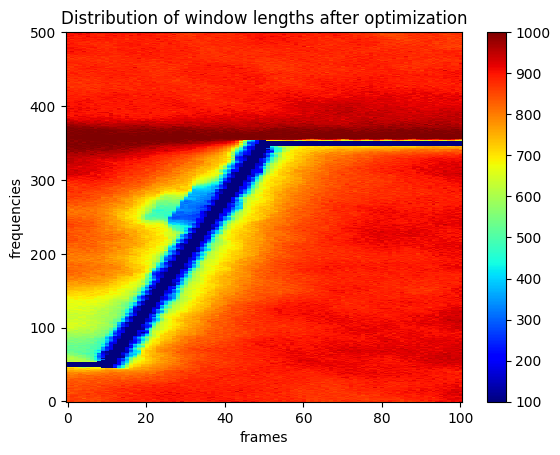

100.0 1000.0 809.38446
finished on epoch 99 with (unregularized) loss 8.769234657287598


In [ ]:
from dstft import fastDSTFT

batch_size = 64
x = x_sample.repeat(batch_size, 1).to(device)
fastdstft = fastDSTFT(x, 
                    window_function='beta',  # 'hann, 'beta'
                    initial_win_length=577,
                    support=1_000, 
                    stride=50,
                    spline_degree = 3,
                    #memory_intensity = "low"
                    )
#x = x.to("cpu")

#fastdstft = torch.compile(fastdstft, mode="default")  # earlier no difference, now crash
with torch.no_grad():
#    fastdstft.window_lengths.data.uniform_(100, 1000)
#fastdstft.warm_start()
    spec = fastdstft(x)  # making one calculation to avoid overhead
    fastdstft.plot(spec, title="before optimization")
    #fastdstft.plot(spec, title="after warm-start")

params = [{'params': fastdstft.parameters(),'lr': 100.0}] 
opt = torch.optim.Adam(params)
sch = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=opt, mode='min', factor=.1, patience=19)

fwtimes = []
bwtimes = []
othertimes = []
times = []
#cpu_mem_before = []
#cpu_mem_after = []

errs = []
err = entropy_loss(spec) + reg* (fastdstft.window_lengths.diff(dim=0)[:, :-1].pow(2) + fastdstft.window_lengths.diff(dim=1)[:-1].pow(2) + torch.finfo(x.dtype).eps).sqrt().mean()
errs.append(err.item())

mini_loss = lambda x: x.sum() * 0 +1

lr_decrease = []
lr = opt.param_groups[0]['lr']
import torch
import psutil, os
def get_cpu_mem():
    return psutil.Process(os.getpid()).memory_info().rss / 1e6  # in MB
#import gc
#gc.enable()
#gc.disable()
for epoch in range(100):  # 1_000
    print(epoch)
    #cpu_mem_before.append(get_cpu_mem())

    #opt.zero_grad()
    for param in fastdstft.parameters():
        param.grad = None

    tic()
    spec = fastdstft(x)  #(), .low_memory_forward()
    fwtimes.append(toc(print_elapsed=False))

    #tic()
    # this takes 0.002*batch_size on gpu, and 0.0001*batch_size on cpu
    # 0.003 when moving to cpu, although the computation is faster. 
    # i guess this is not a problem in real applications, when this is not the last layer
    err = entropy_loss(spec) + reg* (fastdstft.window_lengths.diff(dim=0)[:, :-1].pow(2) + fastdstft.window_lengths.diff(dim=1)[:-1].pow(2) + torch.finfo(x.dtype).eps).sqrt().mean()
    errs.append(err.item())
    #with torch.profiler.profile() as prof:
    #othertimes.append(toc(print_elapsed=False))

    tic()
    err.backward()
    bwtimes.append(toc(print_elapsed=False))

    opt.step()
    sch.step(err)
    
    fastdstft.put_windows_back()  # putting window lengths back in the range [100, 1000]

    #cpu_mem_after.append(get_cpu_mem())
    if opt.param_groups[0]['lr'] < lr:  # lr has decreased
        lr_decrease.append(epoch)
        lr = opt.param_groups[0]['lr']
        if lr < 100:  #1:
            break

fwtimes = np.array(fwtimes[1:])
bwtimes = np.array(bwtimes[1:])
#othertimes = np.array(othertimes)
#cpu_mem_before = np.array(cpu_mem_before)
#cpu_mem_after = np.array(cpu_mem_after)
#print(cpu_mem_after.min())
#print(cpu_mem_after.max())
#memdiff1 = cpu_mem_after -cpu_mem_before  # memory change during iteration
#memdiff2 = cpu_mem_before[1:] -cpu_mem_after[:-1]  # memory change between iterations
#memdiffs = np.concat([memdiff1, memdiff2])
plt.plot(fwtimes, 'r')
plt.plot(bwtimes, 'b')
#plt.plot(cpu_mem_before*fwtimes.max()/cpu_mem_before.max(), 'y')
#plt.plot(cpu_mem_after*fwtimes.max()/cpu_mem_after.max(), 'k')
#plt.plot(memdiff1*fwtimes.max()/memdiffs.max(), 'g')
#plt.plot(memdiff2*fwtimes.max()/memdiffs.max(), 'k')

#print(np.mean(othertimes)/batch_size)
plt.title((np.mean(fwtimes)+np.mean(bwtimes))/batch_size)
plt.show()

plt.plot(errs)
plt.plot(lr_decrease, [errs[i] for i in lr_decrease], 'ro')
plt.show()

spec = fastdstft(x)
fastdstft.plot(spec, title="after optimization")

window_lengths = fastdstft.window_lengths.detach().cpu().numpy()
print(window_lengths.min(), window_lengths.max(), window_lengths.mean())
print(f"finished on epoch {epoch} with (unregularized) loss {entropy_loss(spec).item()}")

In [21]:
adstftdevice = "cpu"  # does not work on gpu
from dstft import ADSTFT
x = x_sample.repeat(batch_size, 1).to(adstftdevice)
dstft = ADSTFT(x_sample, win_length=577, support=1_000, stride=50, win_requires_grad=True, stride_requires_grad=False, win_p='tf', win_min=100
               ).to(adstftdevice)

batch_size = 4
spec, *_ = dstft(x)

fwtimes = []
bwtimes = []

lr_decrease = []
lr = opt.param_groups[0]['lr']
errs = []
params = [{'params': dstft.parameters(),'lr': 100.0}] 
opt = torch.optim.Adam(params)
sch = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=opt, mode='min', factor=.1, patience=19)

for epoch in range(10):
    for param in dstft.parameters():
        param.grad = None

    tic()
    spec, *_ = dstft(x)
    fwtimes.append(toc(print_elapsed=False))

    err = entropy_loss(spec) + reg* (dstft.win_length.diff(dim=0)[:, :-1].pow(2) + dstft.win_length.diff(dim=1)[:-1].pow(2) + torch.finfo(x.dtype).eps).sqrt().mean()
    errs.append(err.item())

    tic()
    err.backward()
    bwtimes.append(toc(print_elapsed=False))

    opt.step()
    sch.step(err)
    
    if opt.param_groups[0]['lr'] < lr:  # lr has decreased
        lr_decrease.append(epoch)
        lr = opt.param_groups[0]['lr']
        if lr < 1:
            break
print(np.mean(fwtimes)/batch_size)
print(np.mean(bwtimes)/batch_size)
print((np.mean(fwtimes)+np.mean(bwtimes))/batch_size)
# handles batches of up to 8 at 2.4 per sample, fastest at 4 with 1.1


0.4367662131786346
0.6705415666103363
1.1073077797889708
